In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/Clinic/master/ultima_all_clean.csv')
df = df.set_index('hn')
df_clean_column = df.drop(['appearance','Wardsize','RHlvsi','depth','nodeyiel','vgmargin','pelvicme','adnmet'],axis = 1)
df_clean = df_clean_column.dropna(axis = 0)
y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis = 1).values
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X_res,y_res = sm.fit_resample(X,y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=0)

# Selection

## 1.SelectKbest

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
fs = SelectKBest(chi2, k=5)
fs.fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

from sklearn.decomposition import PCA
fr = PCA(n_components=3)
fr.fit(X_train)
X_train = fr.transform(X_train)
X_test = fr.transform(X_test)

## 2.GenericUnivariateSelect

In [ ]:
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import chi2
fs = GenericUnivariateSelect(chi2, mode='k_best', param=5)
fs.fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

from sklearn.decomposition import PCA
fr = PCA(n_components=3)
fr.fit(X_train)
X_train = fr.transform(X_train)
X_test = fr.transform(X_test)

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# Model

## 1.Support Vector machine

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
params = {
    'C' : [1,2,4,8,16,32], # High C = Overfitting
    'gamma' : [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32] # High gamma = Overfitting
}
clf = GridSearchCV(SVC(),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 4, 'gamma': 16}
10CV accuracy : 89.04184600669535


In [4]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm) # ทดสอบ
print("Test accuracy : "+str(sum(y_test == y_predict)/len(y_test)*100))

Test accuracy : 90.8203125


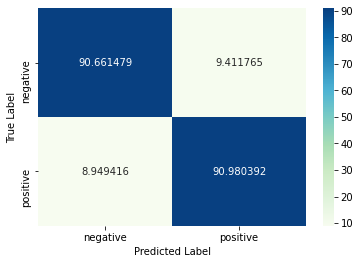

In [5]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt="f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

## 2.RandomForest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators' : [10,50,100],
    'min_samples_leaf' : [1,2,4],
    'max_features' : ['sqrt',0.5,0.8]
}
clf = GridSearchCV(RandomForestClassifier(random_state=0),params, cv = 10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
10CV accuracy : 90.80248684839789


In [8]:
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
sum(y_test == y_predict)/len(y_test)

0.90234375

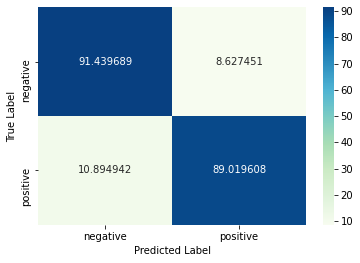

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt="f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

## 3.Extratree

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators' : [10,50,100],
    'min_samples_leaf' : [1,2,4],
    'max_features' : ['sqrt',0.5,0.8]
}
clf = GridSearchCV(ExtraTreesClassifier(random_state=0),params, cv = 5)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50}
10CV accuracy : 91.14518912699555


In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm) # ทดสอบ
print("Test accuracy : "+str(sum(y_test == y_predict)/len(y_test)*100))

Test accuracy : 91.40625


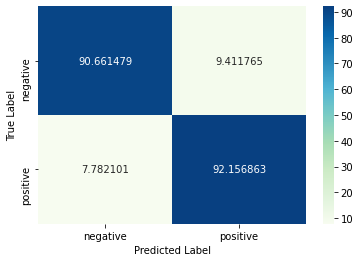

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt="f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()